Import data and inspect

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Noah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


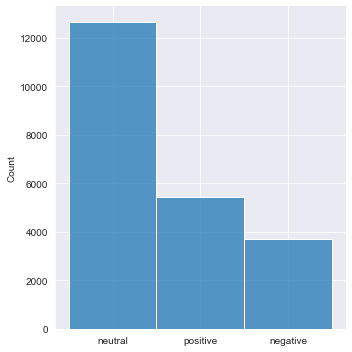

In [85]:
#import functions as f
import pandas as pd
import nltk

nltk.download('stopwords')

train_data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',') # this should only be used for the submission

#print(train_data.sentiment)
cols = train_data.columns

# Plot class distributions
import seaborn as sns
sns.displot([x[0] for x in train_data[['sentiment']].values], discrete=True, bins=3)

# convert training data to numbers for future binarization
#train_data['sentiment'] = train_data['sentiment'].replace(['positive', 'negative', #'neutral'], [1, -1, 0])

# code to convert back to label
#df[column] = df[column].replace([1, -1, 0], ['positive', 'negative', 'neutral'])


In [68]:
# Extract raw training tweets from df
X_train_raw = [x[0] for x in train_data[['text']].values]

# Extract raw training sentiment data from df
Y_train = [x[0] for x in train_data[['sentiment']].values] # y training data

# Extract test tweets from test.csv/test_data df
X_test_raw = [x[0] for x in test_data[['text']].values]

from collections import Counter
print("Class distributions in Training set: ", Counter(Y_train))
print("Number of samples in Kaggle Testing set: ", len(X_test_raw))


print("Raw tweet example: {}\n with sentiment: ({})".format(X_train_raw[1], Y_train[1]))

Class distributions in Training set:  Counter({0: 12659, 1: 5428, -1: 3715})
Number of samples in Kaggle Testing set:  6099

Raw tweet example:  is anybody going to the radio station tomorrow to see shawn? me and my friend may go but we would like to make new friends/meet there (:	
 with sentiment: (1)


Data cleaning

In [70]:
# Clean the training and test data
# remove random stuff, remove stopwords, stem the word, etc...
from functions import preprocess_tweets
X_train_clean = [preprocess_tweets(tweet) for tweet in X_train_raw] # X training data

# -> Kaggle Parts
X_test_clean = [preprocess_tweets(tweet) for tweet in X_test_raw] # for final submission on kaggle
# extract labels for future predictions
Y_test_labels = [x[0] for x in test_data[['id']].values]
# <- End Kaggle Parts

print("Cleaned tweet example:\n {}\nwith sentiment: ({})".format(X_train_clean[1], Y_train[1]))


Cleaned tweet example:
 anybodi go radio station tomorrow see shawn friend may go would like make new friend meet emojismil
with sentiment: (1)


Initialise Classifiers

In [33]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

LR = LogisticRegression(random_state=1, C=1.0, max_iter=2000)
RFC = RandomForestClassifier(random_state=1, criterion='gini', n_estimators=100)
LSVC = LinearSVC(C=0.1)
MNB = MultinomialNB(alpha=1)

# TODO remove this f i dont use it
LR_base = LogisticRegression(random_state=1, C=1.0, max_iter=2000)
RFC_base = RandomForestClassifier(random_state=1, criterion='gini', n_estimators=100)
LSVC_base = LinearSVC(C=0.1)
MNB_base = MultinomialNB(alpha=1)

estimators = [('lr',LR),
              ('rf', RFC),
              ('lsvc', LSVC),
              ('mnb', MNB)]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
ensemble_clf = VotingClassifier(estimators=estimators)


Grid Search for best parameters - performed using BoW

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'lr__C': [1.0, 50.0, 100.0],
           'lr__max_iter':[1000, 2000],
           'rf__n_estimators': [20, 100],
           'lsvc__C': [0.1, 0.5, 1],
           'mnb__alpha': [0.00001, 1]}

# Grid search the best parameters for the Majority Voting classifier
#grid = GridSearchCV(estimator=ensemble_clf, param_grid=params, cv=2, scoring='accuracy'
# verbose=3)
#grid.fit(X_train_bow, Y_train)

# print best params from grid search
#grid.cv_results_['params'][grid.best_index_]


Ensemble/Stacking Method using BoW - No oversampling/undersampling - Scoring = Accuracy

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score

# Vectorize the training and test data using BoW approach
vec_bow = CountVectorizer(ngram_range=(1, 2))
vec_bow.fit(X_train_clean)
X_train_bow = vec_bow.transform(X_train_clean)
X_test_bow = vec_bow.transform(X_test_clean)

In [ ]:
# for clf, label in zip([ensemble_clf, stacking_clf], ['Majority Voting', 'Stacking']):
#     scores =cross_val_score(clf, X_train_bow, Y_train, scoring='accuracy', cv=2, n_jobs=-1)
#     print("Accuracy: %0.2f (+/- %0.2f) [%s] (BoW)" % (scores.mean(), scores.std(), label))

Ensemble/Stacking Method using Tfid - No oversampling/undersampling - Scoring = Accuracy #TODO remove this

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score

# Vectorize the training and test data
vec_tfid = TfidfVectorizer(use_idf = True,
                           ngram_range=(1, 2),
                           sublinear_tf=True)

vec_tfid.fit(X_train_clean)
X_train_Tfid = vec_tfid.transform(X_train_clean)
X_test_Tfid = vec_tfid.transform(X_test_clean)

In [ ]:
# for clf, label in zip([ensemble_clf, stacking_clf], ['Majority Voting', 'Stacking']):
#     scores =cross_val_score(clf, X_train_Tfid, Y_train, scoring='accuracy', cv=2, n_jobs=-1)
#     print("Accuracy: %0.2f (+/- %0.2f) [%s] (Tfid)" % (scores.mean(), scores.std(), label))


Accuracy scores for classifiers performance LR, RFC, LSVC, MNB - BoW

In [ ]:
for clf, label in zip([RFC, LR, LSVC, MNB, ensemble_clf, stacking_clf], ['Random Forest Classifier', 'Logistic Regression', 'Linear SVM', 'Multinominal Naive Bayes', 'Majority Voting', 'Stacking']):
    scores =cross_val_score(clf, X_train_bow, Y_train, scoring='accuracy', cv=2, n_jobs=-1)
    print("Accuracy: %0.2f (+/- %0.2f) [%s] (BoW)" % (scores.mean(), scores.std(), label))


Accuracy scores for classifiers performance LR, RFC, LSVC, MNB - Tfid

In [ ]:
for clf, label in zip([RFC, LR, LSVC, MNB, ensemble_clf, stacking_clf], ['Random Forest Classifier', 'Logistic Regression', 'Linear SVM', 'Multinominal Naive Bayes', 'Majority Voting', 'Stacking']):
    scores =cross_val_score(clf, X_train_bow, Y_train, scoring='accuracy', cv=2, n_jobs=-1)
    print("Accuracy: %0.2f (+/- %0.2f) [%s] (Tfid)" % (scores.mean(), scores.std(), label))


Undersample from the dataset's majority class

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
# initialise undersampler
undersampler = RandomUnderSampler(sampling_strategy='majority')

X_train_clean_reshape = pd.DataFrame(X_train_clean)

# undersample the entire dataset
X_train_under, y_train_under = undersampler.fit_resample(X_train_clean_reshape, Y_train)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='not majority')
X_train_over, y_train_over = oversampler.fit_resample(X_train_clean_reshape, Y_train)

In [ ]:
# inspect
#print(X_train_under.head)
#print(y_train_under)

# Plot distribution of undersampled data
sns.displot([x for x in y_train_under], discrete=True, bins=3)
# summarize class distribution
print("Before undersampling: ", Counter(Y_train))
print("After undersampling: ", Counter(y_train_under))


Accuracy scores for classifiers, under-sampled, BoW

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize the training and test data using BoW approach
vec_bow_undersample = CountVectorizer(ngram_range=(1, 2))
vec_bow_undersample.fit(X_train_under.stack())
X_train_bow_undersample = vec_bow.transform(X_train_under.stack())
#X_test_bow = vec_bow.transform(X_test_clean)

In [30]:
from sklearn.model_selection import cross_val_score
for clf, label in zip([RFC, LR, LSVC, MNB, ensemble_clf, stacking_clf], ['Random Forest Classifier', 'Logistic Regression', 'Linear SVM', 'Multinominal Naive Bayes', 'Majority Voting', 'Stacking']):
    scores =cross_val_score(clf, X_train_bow_undersample, y_train_under, scoring='accuracy', cv=2, n_jobs=-1)
    print("Accuracy: %0.2f (+/- %0.2f) [%s] (BoW, Undersampling)" % (scores.mean(), scores.std(), label))

Accuracy: 0.61 (+/- 0.01) [Random Forest Classifier] (BoW, Undersampling)
Accuracy: 0.64 (+/- 0.01) [Logistic Regression] (BoW, Undersampling)
Accuracy: 0.64 (+/- 0.01) [Linear SVM] (BoW, Undersampling)
Accuracy: 0.62 (+/- 0.00) [Multinominal Naive Bayes] (BoW, Undersampling)


Accuracy scores for classifiers, under-sampled, tfid

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec_tfid_undersample = TfidfVectorizer(use_idf = True,
                                      ngram_range=(1, 2),
                                      sublinear_tf=True)
vec_tfid_undersample.fit(X_train_under.stack())
X_train_tfid_undersample = vec_tfid_undersample.transform(X_train_under.stack())

In [31]:
from sklearn.model_selection import cross_val_score
for clf, label in zip([RFC, LR, LSVC, MNB, ensemble_clf, stacking_clf], ['Random Forest Classifier', 'Logistic Regression', 'Linear SVM', 'Multinominal Naive Bayes', 'Majority Voting', 'Stacking']):
    scores =cross_val_score(clf, X_train_tfid_undersample, y_train_under, scoring='accuracy', cv=2, n_jobs=-1)
    print("Accuracy: %0.2f (+/- %0.2f) [%s] (Tfid, Undersampling)" % (scores.mean(), scores.std(), label))

Accuracy: 0.60 (+/- 0.00) [Random Forest Classifier] (Tfid, Undersampling)
Accuracy: 0.63 (+/- 0.00) [Logistic Regression] (Tfid, Undersampling)
Accuracy: 0.62 (+/- 0.00) [Linear SVM] (Tfid, Undersampling)
Accuracy: 0.55 (+/- 0.00) [Multinominal Naive Bayes] (Tfid, Undersampling)


Predict the Kaggle dataset using Stacking Classifier + BoW + Undersampling

In [ ]:
# Try this out on the kaggle dataset
stacking_clf.fit(X_train_bow_undersample, y_train_under)
kaggle_submit_bow = stacking_clf.predict(X_test_bow)

Implement a dummy classifier

In [87]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_bow_undersample, y_train_under)

dummy_scores = cross_val_score(dummy_clf, X_train_clean, Y_train, scoring='accuracy', cv=5, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f) [%s] (Full dataset)" % (dummy_scores.mean(), dummy_scores.std(), "Zero R"))

dummy_scores_under = cross_val_score(dummy_clf, X_train_under, y_train_under, scoring='accuracy', cv=5, n_jobs=-1)
print("Accuracy: %0.2f (+/- %0.2f) [%s] (Undersampled)" % (dummy_scores.mean(), dummy_scores.std(), "Zero R"))


Accuracy: 0.58 (+/- 0.00) [Zero R] (Full dataset)
Accuracy: 0.58 (+/- 0.00) [Zero R] (Full dataset)


(                                                       0
 0      user user pay back senior citizen medicar serv...
 1      stop post pictur januari charli hebdo attack t...
 2      death death el go aleppo syria standwithaleppo...
 3                                  user wait maduro turn
 4      cheeto nazi mad fat as look like tub curdl ora...
 ...                                                  ...
 12853  last minut anyon want go sam smith w tomorrow ...
 12854  go red sox game tomorrow even though im yanke ...
 12855  tonight user cape guest user jimmi second favo...
 12856  paul dunn tie st open he proud uabblaz shutout...
 12857  user use moto g nd gen month absolut delight s...
 
 [12858 rows x 1 columns],
 [-1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,

Output results to CSV for kaggle - undersampling

Oversampling code - didnt provide any useful discoveries

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter


X_train_clean_reshape = pd.DataFrame(X_train_clean)

# oversample the entire dataset
oversampler = RandomOverSampler(sampling_strategy='not majority')
X_train_over, y_train_over = oversampler.fit_resample(X_train_clean_reshape, Y_train)
# inspect
#print(X_train_over.head)
#print(y_train_over)

# Plot distribution of oversampled data
sns.displot([x for x in y_train_over], discrete=True, bins=3)
# summarize class distribution
print("Before oversampling: ", Counter(Y_train))
print("After oversampling: ", Counter(y_train_over))

from sklearn.feature_extraction.text import CountVectorizer

# Vectorize the training and test data using BoW approach
vec_bow_oversample = CountVectorizer(ngram_range=(1, 2))
vec_bow_oversample.fit(X_train_over.stack())
X_train_bow_oversample = vec_bow.transform(X_train_over.stack())
#X_test_bow = vec_bow.transform(X_test_clean)
from sklearn.model_selection import cross_val_score

for clf, label in zip([RFC, LR, LSVC, MNB, ensemble_clf, stacking_clf],
                      ['Random Forest Classifier', 'Logistic Regression', 'Linear SVM', 'Multinominal Naive Bayes',
                       'Majority Voting', 'Stacking']):
    scores = cross_val_score(clf, X_train_bow_oversample, y_train_over, scoring='accuracy', cv=2, n_jobs=-1)
    print("Accuracy: %0.2f (+/- %0.2f) [%s] (BoW, Oversampling)" % (scores.mean(), scores.std(), label))

from sklearn.feature_extraction.text import TfidfVectorizer
vec_tfid_oversample = TfidfVectorizer(use_idf=True,
                                       ngram_range=(1, 2),
                                       sublinear_tf=True)
vec_tfid_oversample.fit(X_train_over.stack())
X_train_tfid_oversample = vec_tfid_oversample.transform(X_train_over.stack())
from sklearn.model_selection import cross_val_score

for clf, label in zip([RFC, LR, LSVC, MNB, ensemble_clf, stacking_clf],
                      ['Random Forest Classifier', 'Logistic Regression', 'Linear SVM', 'Multinominal Naive Bayes',
                       'Majority Voting', 'Stacking']):
    scores = cross_val_score(clf, X_train_tfid_oversample, y_train_over, scoring='accuracy', cv=2, n_jobs=-1)
    print("Accuracy: %0.2f (+/- %0.2f) [%s] (Tfid, Oversampling)" % (scores.mean(), scores.std(), label))